<a href="https://colab.research.google.com/github/Sameer-Tahir/Project_DS/blob/main/DL_Models/LightGBMFeatureBased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Sameer-Tahir/Project_DS.git

Cloning into 'Project_DS'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 339 (delta 47), reused 9 (delta 9), pack-reused 268 (from 2)
Receiving objects: 100% (339/339), 25.44 MiB | 17.54 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [2]:
# Import libraries
import pandas as pd   # data processing
import numpy as np    # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import json
from tensorflow.keras import layers, models, callbacks
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras import layers, models, callbacks
import numpy as np, joblib
from sklearn.metrics import precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras import layers, models
import xgboost as xgb
import lightgbm as lgb
from xgboost.callback import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [3]:
# -----------------------
# Load your splits
# -----------------------
train_df = pd.read_csv("dfk1_train.csv")
val_df   = pd.read_csv("dfk1_val.csv")
test_df  = pd.read_csv("dfk1_test.csv")

In [4]:
!unzip -o dl_preprocessed.zip

Archive:  dl_preprocessed.zip
  inflating: dl_data_windows.npz     
  inflating: label_encoder.pkl       
  inflating: scaler.pkl              


In [5]:
# Load arrays
data = np.load("dl_data_windows.npz", allow_pickle=True)
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val     = data["X_val"],   data["y_val"]
X_test, y_test   = data["X_test"],  data["y_test"]
feature_cols     = data["feature_cols"].tolist()
classes          = data["classes"]

# Load encoder & scaler
le = joblib.load("label_encoder.pkl")
scaler = joblib.load("scaler.pkl")

print("✅ Data loaded successfully")
print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape, y_val.shape)
print("Test:",  X_test.shape, y_test.shape)
print("Classes:", classes)

✅ Data loaded successfully
Train: (4835, 6, 222) (4835,)
Val: (591, 6, 222) (591,)
Test: (590, 6, 222) (590,)
Classes: ['aggressive-scan' 'cryptojacking' 'icmp-flood' 'icmp-fragmentation'
 'icmp-fragmentation_old' 'none' 'os-fingerprinting' 'os-scan' 'port-scan'
 'push-ack-flood' 'serice-detection' 'service-detection' 'syn-flood'
 'syn-stealth' 'synonymous-ip-flood' 'tcp-flood' 'udp-flood' 'vuln-scan']


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✅ LightGBM (Top-N features) Results
Accuracy: 0.9050847457627119
Macro-F1: 0.7708578342718985
                        precision    recall  f1-score   support

       aggressive-scan       0.71      0.67      0.69        18
         cryptojacking       1.00      0.99      1.00       165
            icmp-flood       0.75      0.69      0.72        13
    icmp-fragmentation       1.00      1.00      1.00        13
icmp-fragmentation_old       0.29      0.33      0.31         6
                  none       1.00      1.00      1.00       220
     os-fingerprinting       0.56      0.69      0.62        13
               os-scan       0.62      0.83      0.71         6
             port-scan       0.72      0.68      0.70        19
        push-ack-flood       1.00      1.00      1.00        12
      serice-detection       1.00      0.83      0.91         6
     service-detection       0.33      0.29      0.31        14
             syn-flood       1.00      0.92      0.96        13
        

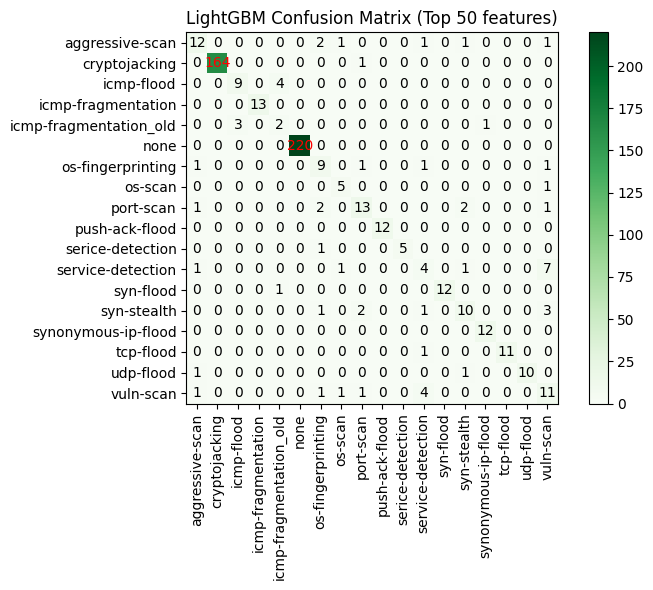

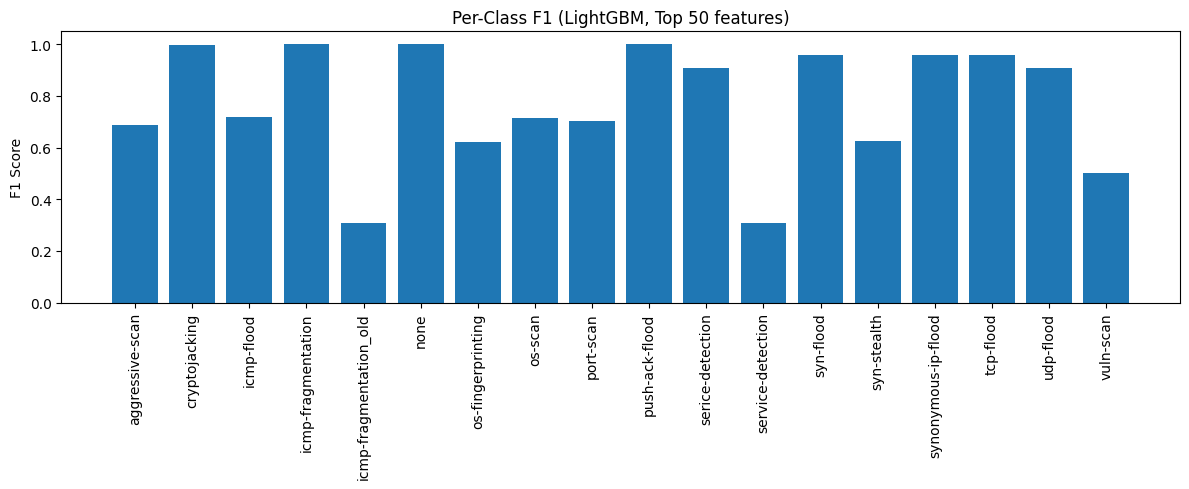

📂 Saved: results_lightgbm_top50.json and plots


In [8]:
# ===============================
# Flatten + Top-N feature selection via LGBM
# ===============================
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import json

# 0) Flatten raw data for tree-based models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat   = X_val.reshape(X_val.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

print("Shapes after flatten:", X_train_flat.shape, X_val_flat.shape, X_test_flat.shape)

# 1) Fit a quick LightGBM
base_lgb = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multiclass",
    class_weight="balanced",
    random_state=42
)
base_lgb.fit(X_train_flat, y_train, eval_set=[(X_val_flat, y_val)], eval_metric="multi_logloss")

# 2) Get importances and pick top-N indices
N = 50  # try 30 / 50 / 100 etc
importances = base_lgb.feature_importances_
top_idx = np.argsort(importances)[::-1][:N]

# 3) Map indices to feature names
selected_features = [feature_cols[i] for i in top_idx]
print(f"\n🎯 Top {N} Selected Features:")
for rank, feat in enumerate(selected_features, 1):
    print(f"{rank:02d}. {feat}")

# 4) Slice to top-N features
X_train_sel = X_train_flat[:, top_idx]
X_val_sel   = X_val_flat[:,   top_idx]
X_test_sel  = X_test_flat[:,  top_idx]

print(f"Selected top {N} features. Shapes:", X_train_sel.shape, X_val_sel.shape, X_test_sel.shape)

# 5) Retrain LightGBM on reduced features
lgb_sel = lgb.LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multiclass",
    class_weight="balanced",
    random_state=42
)
lgb_sel.fit(X_train_sel, y_train, eval_set=[(X_val_sel, y_val)], eval_metric="multi_logloss")

# 6) Evaluate
y_pred_lgb = lgb_sel.predict(X_test_sel)
acc_lgb = accuracy_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb, average="macro")
report_lgb = classification_report(y_test, y_pred_lgb, target_names=classes, zero_division=0)
cm_lgb = confusion_matrix(y_test, y_pred_lgb)

print("\n✅ LightGBM (Top-N features) Results")
print("Accuracy:", acc_lgb)
print("Macro-F1:", f1_lgb)
print(report_lgb)

# 7) Confusion Matrix Plot
plt.figure(figsize=(8, 6))
plt.imshow(cm_lgb, cmap="Greens")
plt.title(f"LightGBM Confusion Matrix (Top {N} features)")
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=90)
plt.yticks(np.arange(len(classes)), classes)
for i in range(cm_lgb.shape[0]):
    for j in range(cm_lgb.shape[1]):
        plt.text(j, i, cm_lgb[i, j], ha="center", va="center",
                 color="red" if cm_lgb[i, j] > cm_lgb.max()/2 else "black")
plt.tight_layout()
plt.savefig(f"LGBM_confusion_matrix_top{N}.png")
plt.show()

# 8) Per-class F1 Plot
prec, rec, f1_pc, support = precision_recall_fscore_support(y_test, y_pred_lgb, zero_division=0)
plt.figure(figsize=(12, 5))
plt.bar(classes, f1_pc)
plt.xticks(rotation=90)
plt.title(f"Per-Class F1 (LightGBM, Top {N} features)")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.savefig(f"LGBM_f1_per_class_top{N}.png")
plt.show()

# 9) Save results
results_lgb = {
    "accuracy": float(acc_lgb),
    "macro_f1": float(f1_lgb),
    "report": report_lgb,
    "confusion_matrix": cm_lgb.tolist(),
    "topN": N,
    "top_feature_indices": top_idx.tolist(),
    "top_feature_names": selected_features
}
with open(f"results_lightgbm_top{N}.json", "w") as f:
    json.dump(results_lgb, f, indent=4)

print(f"📂 Saved: results_lightgbm_top{N}.json and plots")


In [9]:
# Print top features with importance
top_features_with_scores = sorted(
    zip(importances[top_idx], selected_features),
    key=lambda x: x[0],
    reverse=True
)

print("\n📊 Top Features Ranked by Importance:")
for score, feat in top_features_with_scores:
    print(f"{feat}: {score}")


📊 Top Features Ranked by Importance:
skb_kfree_skb: 3508
time: 3459
strex_fail_spec: 3397
msec: 3132
syscalls_sys_enter_getpid: 3131
bus_access_wr: 2989
kmem_kfree: 2719
ase_spec: 2614
unaligned_st_spec: 2557
l2d_cache_wb_clean: 2471
fib_fib_table_lookup: 2446
skb_consume_skb: 2393
vfp_spec: 2387
node-stores: 2058
net_net_dev_queue: 2013
exc_irq: 1936
kmem_mm_page_alloc: 1903
bus_access_periph: 1748
kmem_kmalloc: 1689
kmem_kmem_cache_alloc: 1682
kmem_mm_page_free: 1611
net_netif_receive_skb: 1609
syscalls_sys_enter_read: 1575
bus_access: 1542
unaligned_ld_spec: 1489
irq_irq_handler_entry: 1488
kmem_rss_stat: 1448
raw_syscalls_sys_enter: 1436
kmem_kmem_cache_free: 1410
ttbr_write_retired: 1397
net_napi_gro_receive_entry: 1383
unaligned_ldst_spec: 1329
dsb_spec: 1328
rc_ld_spec: 1323
br_immed_spec: 1299
isb_spec: 1295
l1d_cache_wb_clean: 1286
net_net_dev_start_xmit: 1259
exc_svc: 1259
bus_access_normal: 1215
syscalls_sys_enter_ppoll: 1168
branch-loads: 1163
iTLB-load-misses: 1162
irq_so

In [10]:
print("Original:", X_train_flat.shape)
print("Selected:", X_train_sel.shape)

Original: (4835, 1332)
Selected: (4835, 50)
